# Capstone Notebook

In [12]:
import pandas as pd
import numpy as np
import json
import folium
import requests
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

## Read in NY neighborhoods geo data

In [13]:
with open('../newyork_data.json') as json_data:
    ny_data = json.load(json_data)

In [14]:
neighborhoods_data = ny_data['features']
neighborhoods_data[0]

{'geometry': {'coordinates': [-73.84720052054902, 40.89470517661],
  'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.1',
 'properties': {'annoangle': 0.0,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661],
  'borough': 'Bronx',
  'name': 'Wakefield',
  'stacked': 1},
 'type': 'Feature'}

In [15]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude']
neighborhoods = pd.DataFrame(columns=column_names)

In [16]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [17]:
neighborhoods.shape

(306, 4)

In [18]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()), neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


In [19]:
nyc_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
nyc_data.shape

(40, 4)

## Make API call to Foursquare to retrieve venue list and categories

In [20]:
CLIENT_ID = '...'
CLIENT_SECRET = '...'
VERSION = '20180605'

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
nyc_venues = getNearbyVenues(names=nyc_data['Neighborhood'],
                                   latitudes=nyc_data['Latitude'],
                                   longitudes=nyc_data['Longitude'])

Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


In [23]:
print(nyc_venues.shape)
nyc_venues.head()

(1182, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop


## Clean the dataset and identify neighborhoods with most cafes and coffee shops

In [24]:
nyc_venues_filtered = nyc_venues[nyc_venues['Venue Category'].isin(['Coffee Shop', 'Café'])]
print(nyc_venues_filtered['Venue Category'].value_counts())
nyc_venues_filtered.head()

Coffee Shop    58
Café           30
Name: Venue Category, dtype: int64


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
4,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
9,Marble Hill,40.876551,-73.91066,Starbucks,40.873755,-73.908613,Coffee Shop
22,Marble Hill,40.876551,-73.91066,Starbucks,40.873234,-73.908730,Coffee Shop
54,Washington Heights,40.851903,-73.93690,Green Juice Cafe,40.851898,-73.934827,Café
59,Washington Heights,40.851903,-73.93690,Le Chéile,40.851459,-73.939989,Café


In [25]:
nyc_venues_grouped = nyc_venues_filtered.groupby('Neighborhood')['Venue Category'].agg(['count'])
nyc_venues_grouped.rename(columns={'count':'Venue Count'}, inplace=True)
nyc_venues_grouped['Neighborhood'] = nyc_venues_grouped.index
nyc_venues_grouped.sort_values(['Venue Count'], ascending=False, inplace=True)
nyc_venues_grouped.reset_index(drop=True, inplace=True)

In [26]:
nyc_venues_grouped['Choice'] = np.where(nyc_venues_grouped['Venue Count']==6,'Top Choice',
                                        np.where(nyc_venues_grouped['Venue Count']==5,'Second Choice',
                                        np.where(nyc_venues_grouped['Venue Count']==4,'Third Choice', '')))
nyc_venues_grouped

,Venue Count,Neighborhood,Choice
0,6,Financial District,Top Choice
1,6,Little Italy,Top Choice
2,5,Washington Heights,Second Choice
3,4,Manhattanville,Third Choice
4,4,Carnegie Hill,Third Choice
5,4,Lower East Side,Third Choice
6,4,Morningside Heights,Third Choice
7,4,Hamilton Heights,Third Choice
8,3,Yorkville,
9,3,Inwood,


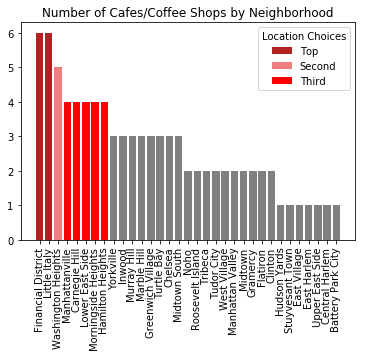

In [27]:
x1 = nyc_venues_grouped[nyc_venues_grouped['Choice']=='Top Choice']['Neighborhood']
y1 = nyc_venues_grouped[nyc_venues_grouped['Choice']=='Top Choice']['Venue Count']
x2 = nyc_venues_grouped[nyc_venues_grouped['Choice']=='Second Choice']['Neighborhood']
y2 = nyc_venues_grouped[nyc_venues_grouped['Choice']=='Second Choice']['Venue Count']
x3 = nyc_venues_grouped[nyc_venues_grouped['Choice']=='Third Choice']['Neighborhood']
y3 = nyc_venues_grouped[nyc_venues_grouped['Choice']=='Third Choice']['Venue Count']
x4 = nyc_venues_grouped[nyc_venues_grouped['Choice']=='']['Neighborhood']
y4 = nyc_venues_grouped[nyc_venues_grouped['Choice']=='']['Venue Count']

plt.bar(x1, y1, color='FireBrick', label='Top')
plt.bar(x2, y2, color='LightCoral', label='Second')
plt.bar(x3, y3, color='Red', label='Third')
plt.bar(x4, y4, color='Gray', label='')

plt.title("Number of Cafes/Coffee Shops by Neighborhood", fontsize=12)
plt.xticks(fontsize=10, rotation='vertical')
plt.legend(fontsize=10, title='Location Choices')

labels = []
for index, rows in nyc_venues_grouped.iterrows():
    labels.extend([rows[0], rows[1], rows[2]])

plt.show()

## Create a map of NYC with neighborhoods superimposed on top

In [28]:
nyc_choices = nyc_venues_grouped.merge(nyc_data, how='left', on='Neighborhood')

In [29]:
nyc_choices = nyc_choices[['Choice','Venue Count','Neighborhood','Latitude','Longitude']]
nyc_choices

,Choice,Venue Count,Neighborhood,Latitude,Longitude
0,Top Choice,6,Financial District,40.707107,-74.010665
1,Top Choice,6,Little Italy,40.719324,-73.997305
2,Second Choice,5,Washington Heights,40.851903,-73.936900
3,Third Choice,4,Manhattanville,40.816934,-73.957385
4,Third Choice,4,Carnegie Hill,40.782683,-73.953256
5,Third Choice,4,Lower East Side,40.717807,-73.980890
6,Third Choice,4,Morningside Heights,40.808000,-73.963896
7,Third Choice,4,Hamilton Heights,40.823604,-73.949688
8,,3,Yorkville,40.775930,-73.947118
9,,3,Inwood,40.867684,-73.921210


In [30]:
latitude = 40.7831
longitude = -73.9712

# create map of Manhattan using latitude and longitude values
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=11)

rainbow = ['Gray','Gray','Gray','Red','LightCoral','FireBrick']

# add markers to map
markers_colors = []
for lat, lng, label, count, choice in zip(nyc_choices['Latitude'], nyc_choices['Longitude'], nyc_choices['Neighborhood'], nyc_choices['Venue Count'], nyc_choices['Choice']):
    label = folium.Popup(str(label) + ' ' + str(choice), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[count-1],
        fill=True,
        fill_color=rainbow[count-1],
        fill_opacity=0.7).add_to(map_nyc)  
    
map_nyc